<h1>Regression</h1>

<h2>Import Libaries</h2>

In [1]:
import csv
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

<h2>Laden der Datensätze</h2>

In [2]:
#Load German Sentiment CSV file.
df_de = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_DE_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

#Change the date field
df_de["Date"] = pd.to_datetime(df_de.created_at).apply(lambda x: x.date())

#Change the values of sentiment bert field and add a new field for a numeric value sentiment value 
df_de["sentiment_bert"] = df_de["sentiment_bert"].replace(["neutral", "negative", "positive"], ["NEU", "NEG", "POS"])
df_de["sentiment_bert_value"] = df_de["sentiment_bert"].replace({"NEU": 0, "NEG": -1, "POS": 1})

#Create a new field for a numeric sentiment value
df_de["sentiment_vader_value"] = [1 if i >= 0.05 else -1 if i <= -0.05 else 0 for i in df_de["sentiment_vader"]]

#Create a df for adding the year and week to the df
df_de_week_year = pd.DataFrame([(i.isocalendar().week, i.isocalendar().year, i.isocalendar().weekday) for i in df_de["Date"]],
                               columns=["Week", "Year", "Weekday"])

#Recalulate the week
for each in range(len(df_de_week_year)):
    if ((df_de_week_year.iloc[each]["Weekday"] > 5) & (df_de_week_year.iloc[each]["Week"] != 1)):
        df_de_week_year.iloc[each]["Week"] = df_de_week_year.iloc[each]["Week"] - 1
    elif ((df_de_week_year.iloc[each]["Weekday"] > 5) & (df_de_week_year.iloc[each]["Week"] == 1)):
        df_de_week_year.iloc[each]["Week"] = 52

#Adding the week and year information to the df
df_de[["Week", "Year"]] = df_de_week_year[["Week", "Year"]]

In [3]:
#Load English Sentiment CSV file.
df_en = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

#Change the date field
df_en["Date"] = pd.to_datetime(df_en.created_at).apply(lambda x: x.date())

#Add a new column for a numeric sentiment bert value
df_en["sentiment_bert_value"] = df_en["sentiment_bert"].replace({"NEU": 0, "NEG": -1, "POS": 1})

#Add a new column for a numeric sentiment vader value
df_en["sentiment_vader_value"] = [1 if i >= 0.05 else -1 if i <= -0.05 else 0 for i in df_en["sentiment_vader"]]

#Create a df for adding the year and week to the df
df_en_week_year = pd.DataFrame([(i.isocalendar().week, i.isocalendar().year, i.isocalendar().weekday) for i in df_en["Date"]],
                               columns=["Week", "Year", "Weekday"])

#Recalulate the week
for each in range(len(df_en_week_year)):
    if ((df_en_week_year.iloc[each]["Weekday"] > 5) & (df_en_week_year.iloc[each]["Week"] != 1)):
        df_en_week_year.iloc[each]["Week"] = df_en_week_year.iloc[each]["Week"] - 1
    elif ((df_en_week_year.iloc[each]["Weekday"] > 5) & (df_en_week_year.iloc[each]["Week"] == 1)):
        df_en_week_year.iloc[each]["Week"] = 52
        
#Adding the week and year information to the df
df_en[["Week", "Year"]] = df_en_week_year[["Week", "Year"]]

In [4]:
#Combine the different DFs
df = pd.concat([df_en, df_de]).reset_index(drop=True)

In [120]:
#Change the values from sentiment_bert_value from text to a num value
df["sentiment_bert_value"] = df["sentiment_bert"].replace({"NEU": 0, "NEG": -1, "POS": 1})

#Create a df for adding the year and week to the df
df_week_year = pd.DataFrame([(i.isocalendar().week, i.isocalendar().year) for i in df["Date"]], columns=["Week", "Year"])
#Adding the week and year information to the df
df[["Week", "Year"]] = df_week_year[["Week", "Year"]]

In [5]:
#Load Wirecard finance CSV file.
df_wdi = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/WDI.HM-2.csv", parse_dates=["Date"])
df_wdi = df_wdi.rename(columns={"Adj Close": "Adj_Close"})

#Load Euro Stoxx 50 CSV file.
df_stoxx = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/^STOXX50E.csv", parse_dates=["Date"])
df_stoxx = df_stoxx.rename(columns={"Adj Close": "Adj_Close"})

#Load Visa finance CSV file.
df_visa = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/V.csv", parse_dates=["Date"])
df_visa = df_visa.rename(columns={"Adj Close": "Adj_Close"})

#Load Master Card finance CSV file.
df_ma = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/MA.csv", parse_dates=["Date"])
df_ma = df_ma.rename(columns={"Adj Close": "Adj_Close"})

<h2>Data Preparation</h2>

In [6]:
#Change Date für df_wdi & df
df_wdi["Date"] = pd.to_datetime(df_wdi.Date).apply(lambda x: x.date())
df_stoxx["Date"] = pd.to_datetime(df_stoxx.Date).apply(lambda x: x.date())
df_visa["Date"] = pd.to_datetime(df_visa.Date).apply(lambda x: x.date())
df_ma["Date"] = pd.to_datetime(df_ma.Date).apply(lambda x: x.date())

In [7]:
def create_finance_df(df):
    #Create df for returning
    df_week = pd.DataFrame(columns=["Date", "Week", "Year", "Adj_Close"])
    
    #Start Week
    week = 5
    volume = 0
    
    #To loop through all lines in df
    for each in range(len(df)):
        #Get the date
        each_date = df["Date"][each]
        adj_close = df["Adj_Close"][each]
        
        #Get the Volume of all transactions in a week
        volume = volume + df["Volume"][each]

        #Check if the date is the last date
        if df["Date"][each] == datetime.date(2020,7,31):
            #Get Week Number, start and end day
            week = each_date.isocalendar().week
            year = each_date.isocalendar().year
            end_day = df["Date"].iloc[-1]
            
            #Add data to df
            new_row = pd.DataFrame([[each_date, week, year, adj_close, volume]],
                                   columns=["Date", "Week", "Year", "Adj_Close", "Volume"])
            df_week = pd.concat([df_week, new_row], ignore_index=True)
        else:
            #Get the next week number for checking
            next_week = df["Date"][each+1].isocalendar().week

            #Check if the next day is in another week 
            if each_date.isocalendar().week != next_week:
                #Get week number, year and last date
                week = each_date.isocalendar().week
                year = each_date.isocalendar().year
                end_day = each_date
                
                #Add data to df
                new_row = pd.DataFrame([[each_date, week, year, adj_close, volume]],
                                       columns=["Date", "Week", "Year", "Adj_Close", "Volume"])
                df_week = pd.concat([df_week, new_row], ignore_index=True)
                
                #Set Volume back to 0
                volume = 0
    
    #Add the yield from one week to another
    df_week["returns_week"] = df_week.Adj_Close.pct_change()+1
    #df_week["returns_week_log"] = pd.Series(np.log(np.float64(df_week.Adj_Close))).pct_change()
    

    
    #Return the new DF
    return df_week

In [8]:
def concat_finance_df(df_wdi = df_wdi, df_stoxx = df_stoxx, df_ma = df_ma, df_v = df_visa):
    
    #Create week dfs for all financial dfs
    df_wdi_week = create_finance_df(df_wdi)
    df_stoxx_week = create_finance_df(df_stoxx)
    df_ma_week = create_finance_df(df_ma)
    df_v_week = create_finance_df(df_v)
    
    #combine all dfs
    df_week = pd.concat([df_wdi_week, df_stoxx_week.rename(columns={"returns_week": "returns_stoxx"})["returns_stoxx"]],
                        axis=1)
    df_week = pd.concat([df_week, df_ma_week.rename(columns={"returns_week": "returns_ma"})["returns_ma"]], axis=1)
    df_week = pd.concat([df_week, df_v_week.rename(columns={"returns_week": "returns_visa"})["returns_visa"]], axis=1)
    return df_week

In [9]:
def create_final_df(df_week, df, meta_data = False):
    
    #If meta data like Retweets should be used, this will calculate it.
    if meta_data:
        df["sentiment_bert_value"] = df["sentiment_bert_value"] * ((df["retweet_count"] + 1))
        df["sentiment_vader_value"] = df["sentiment_vader_value"] * ((df["retweet_count"] + 1))
    
    df_sum_year_week_bert = pd.DataFrame(df[["Week", "Year", "sentiment_bert_value"]].
                                    groupby(by=["Year", "Week"]).sum()).reset_index()

    df_sum_year_week_vader = pd.DataFrame(df[["Week", "Year", "sentiment_vader_value"]].
                                    groupby(by=["Year", "Week"]).sum()).reset_index()
    
    df_count_tweets_year_week = pd.DataFrame(df[["Week", "Year", "conversation_id"]].
                                    groupby(by=["Year", "Week"]).
             count()).reset_index().rename(columns={"conversation_id": "count_all_tweets"})
    
    df_week = df_week.merge(df_sum_year_week_bert)
    df_week = df_week.merge(df_sum_year_week_vader)
    df_week = df_week.merge(df_count_tweets_year_week)
    
    return df_week

In [10]:
def create_df(df_twitter = df.copy()):
    df_week = concat_finance_df()
    df_week_reg = create_final_df(df_week, df_twitter)
    
    df_week_reg["dif_sentiment_bert_value"] = df_week_reg["sentiment_bert_value"].diff()
    df_week_reg["dif_sentiment_vader_value"] = df_week_reg["sentiment_vader_value"].diff()

    df_week_reg.dropna(inplace=True)
    df_week_reg = df_week_reg.reset_index(drop=True)

    return df_week_reg

<h2>Linear Regression</h2>

In [11]:
def regression(df, regressor, output):
    
    x = df[regressor]
    y = df[output]
    
    x = sm.add_constant(x)

    model = sm.OLS(y,x).fit()
    
    predictions = model.predict(x)
    
    pritn_model = model.summary()
    
    print(pritn_model)
    
    return predictions, model

<h2>Execute</h2>

In [18]:
regressor = ["dif_sentiment_bert_value", "returns_stoxx", "returns_ma", "returns_visa", "Volume", "count_all_tweets"]

regressand = ["returns_week"]

df_week_reg = create_df()
        
reg_predictions, reg_model = regression(df_week_reg, regressor, regressand)

                            OLS Regression Results                            
Dep. Variable:           returns_week   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     123.1
Date:                Wed, 12 Oct 2022   Prob (F-statistic):           1.73e-68
Time:                        17:45:02   Log-Likelihood:                 308.42
No. Observations:                 234   AIC:                            -602.8
Df Residuals:                     227   BIC:                            -578.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [34]:
regressor = ["dif_sentiment_bert_value", "returns_stoxx", "returns_ma", "returns_visa", "Volume", "count_all_tweets"]
regressor = ["dif_sentiment_vader_value", "returns_stoxx", "returns_ma", "returns_visa", "Volume", "count_all_tweets"]
regressor = ["dif_sentiment_bert_value", "dif_sentiment_vader_value", "returns_stoxx", "returns_ma", "returns_visa", "Volume", "count_all_tweets"]
regressand = ["returns_week"]

df_week_reg = create_df(df)
        
reg_predictions, reg_model = regression(df_week_reg, regressor, regressand)

                            OLS Regression Results                            
Dep. Variable:           returns_week   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     102.3
Date:                Sun, 23 Oct 2022   Prob (F-statistic):           1.86e-66
Time:                        22:04:46   Log-Likelihood:                 306.10
No. Observations:                 234   AIC:                            -596.2
Df Residuals:                     226   BIC:                            -568.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

<h2>Test</h2>

In [20]:
df_week_reg["count_all_tweets"].sum()

114368

In [113]:
df_test = pd.DataFrame([(i.isocalendar().week, i.isocalendar().year, i.isocalendar().weekday) for i in df_en["Date"]],
                               columns=["Week", "Year", "Weekday"])

In [114]:
for each in range(len(df_test)):
#for each in range(15):
    if ((df_test.iloc[each]["Weekday"] > 5) & (df_test.iloc[each]["Week"] != 1)):
        df_test.iloc[each]["Week"] = df_test.iloc[each]["Week"] - 1
    elif ((df_test.iloc[each]["Weekday"] > 5) & (df_test.iloc[each]["Week"] == 1)):
        df_test.iloc[each]["Week"] = 52

In [115]:
df_test.head(15)

,Week,Year,Weekday
0,8,2016,5
1,5,2016,4
2,5,2016,4
3,14,2016,5
4,14,2016,5
5,14,2016,5
6,14,2016,4
7,14,2016,4
8,21,2016,1
9,19,2016,7


In [84]:
df_test.head(15)

,Week,Year,Weekday
0,8,2016,5
1,5,2016,4
2,5,2016,4
3,14,2016,5
4,14,2016,5
5,14,2016,5
6,14,2016,4
7,14,2016,4
8,21,2016,1
9,20,2016,7


In [116]:
len(df_test.loc[df_test["Week"] == 0])

0

In [103]:
df_test.head(15)

,Week,Year,Weekday
0,8,2016,5
1,5,2016,4
2,5,2016,4
3,14,2016,5
4,14,2016,5
5,14,2016,5
6,14,2016,4
7,14,2016,4
8,21,2016,1
9,20,2016,7


<h2>Darstellung</h2>

In [177]:
df_de.groupby("sentiment_bert")["sentiment_bert"].count()

sentiment_bert
NEG    33654
NEU    75312
POS     5478
Name: sentiment_bert, dtype: int64

In [178]:
len(df_de)

114444

In [179]:
(len(df_de.loc[df_de["sentiment_bert"] == "NEU"]) / len(df_de)) * 100

65.80685750235922

In [191]:
df_de["Year"].unique()

array([2016, 2017, 2018, 2019, 2020])

In [235]:
df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEG"]["sentiment_bert_value"]

0      2094
3      1800
6      2422
9      6309
12    21029
Name: sentiment_bert_value, dtype: int64

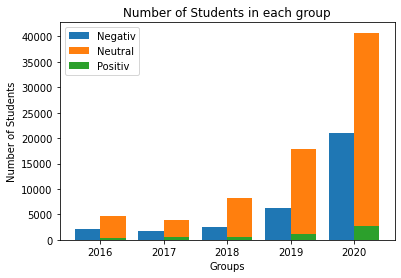

In [256]:
X = df_de["Year"].unique()
Y_NEG = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEG"]["sentiment_bert_value"]
y_NEU = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEU"]["sentiment_bert_value"]
y_POS = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "POS"]["sentiment_bert_value"]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y_NEG, 0.4, label = 'Negativ')
plt.bar(X_axis + 0.2, y_NEU, 0.4, label = 'Neutral')
plt.bar(X_axis + 0.2, y_POS, 0.4, label = 'Positiv')

  
plt.xticks(X_axis, X)
plt.xlabel("Groups")
plt.ylabel("Number of Students")
plt.title("Number of Students in each group")
plt.legend()
plt.show()

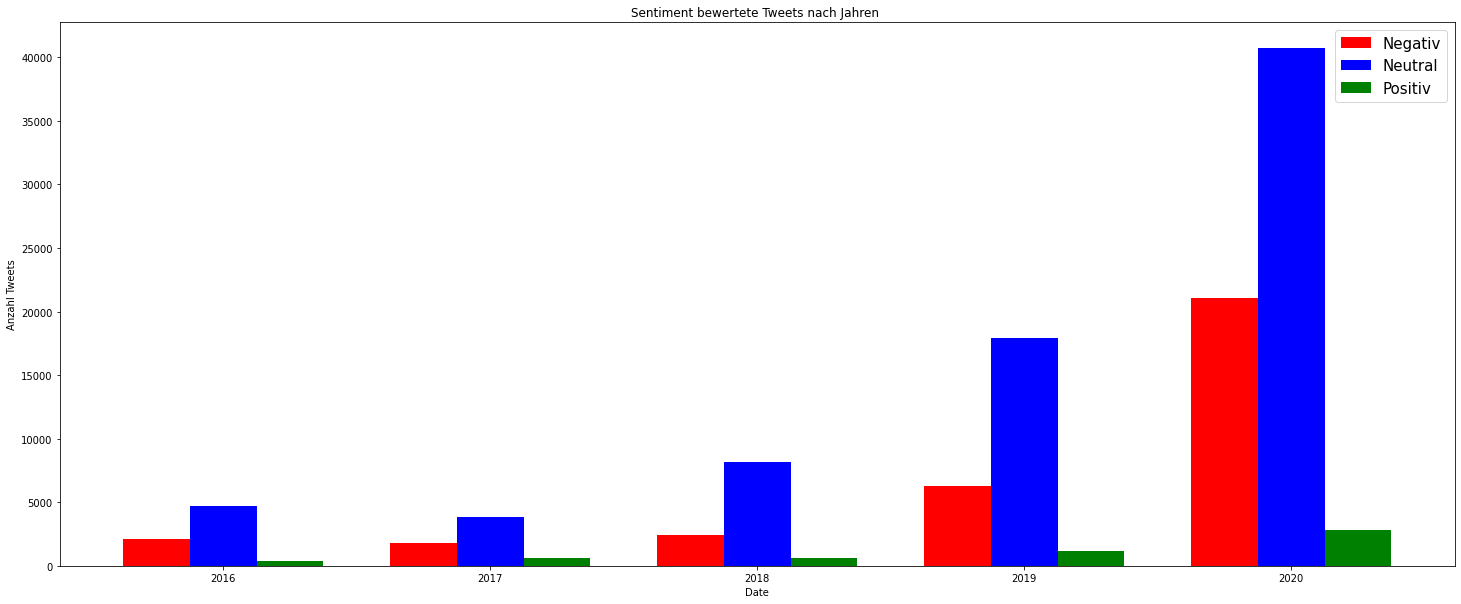

In [281]:
plt.figure(figsize=(25, 10))

N = 5
ind = np.arange(N)
width = 0.25

xvals = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEG"]["sentiment_bert_value"]
bar1 = plt.bar(ind, xvals, width, color = 'r')

yvals = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEU"]["sentiment_bert_value"]
bar2 = plt.bar(ind+width, yvals, width, color='b')

zvals = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "POS"]["sentiment_bert_value"]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'g')

plt.xlabel("Date")
plt.ylabel("Anzahl Tweets")
plt.title("Sentiment bewertete Tweets nach Jahren ")

plt.xticks(ind+width,['2016', '2017', '2018', '2019', '2020'])
plt.legend( (bar1, bar2, bar3), ('Negativ', 'Neutral', 'Positiv'), prop={'size': 15})
plt.show()


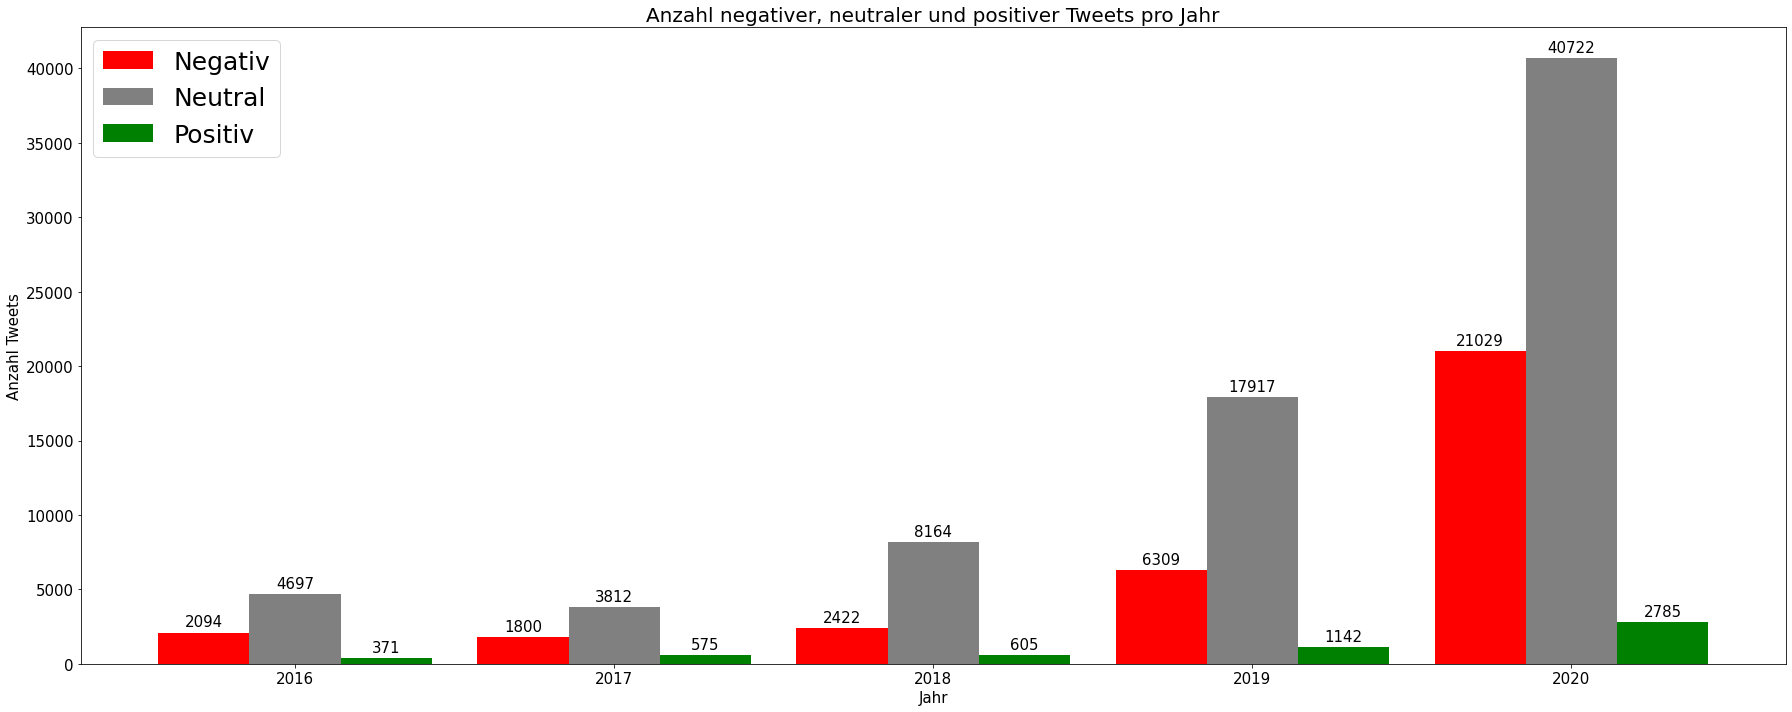

In [404]:
labels = ['2016', '2017', '2018', '2019', '2020']
neg = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEG"]["sentiment_bert_value"]
neu = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEU"]["sentiment_bert_value"]
pos = df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "POS"]["sentiment_bert_value"]

x = [-0.2, 1.2, 2.6, 4, 5.4]
width = 0.4  # the width of the bars

bar_1 = [-0.6, 0.8, 2.2, 3.6, 5]
bar_2 = [-0.2, 1.2, 2.6, 4, 5.4]
bar_3 = [0.2, 1.6, 3, 4.4, 5.8]

fig, ax = plt.subplots(figsize=(25,10))
rects1 = ax.bar(bar_1, neg, width, label='Negativ', color="red")
rects2 = ax.bar(bar_2, neu, width, label='Neutral', color="grey")
rects3 = ax.bar(bar_3, pos, width, label="Positiv", color="green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anzahl Tweets', fontsize=(15))
ax.set_xlabel('Jahr', fontsize=(15))
ax.set_title('Anzahl negativer, neutraler und positiver Tweets pro Jahr', fontsize=(20))
ax.set_xticks(x, labels, fontsize=(15))
ax.legend(fontsize=(25))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(15)

ax.bar_label(rects1, padding=3, fontsize=(15))
ax.bar_label(rects2, padding=3, fontsize=(15))
ax.bar_label(rects3, padding=3, fontsize=(15))

fig.tight_layout()

plt.show()

In [346]:
np.arange(len(labels))-0.4

array([-0.4,  0.6,  1.6,  2.6,  3.6])

In [332]:
np.arange(len(labels))+0.4/2

array([0.2, 1.2, 2.2, 3.2, 4.2])

In [328]:
np.arange(len(labels))+0.4/2

array([0.2, 1.2, 2.2, 3.2, 4.2])

In [300]:
-0,6; -0,2; 0,2; 0,6
0,8; 1,2; 1,6; 2
2,2; 2,6; 3; 3,4
3,6; 4; 4,4; 4,8
5; 5,4; 5,8; 6,2

(4, 2, 4, 6, 5)

In [342]:
(1-0.4)*2

1.2

In [305]:
0.2*3

0.6000000000000001

In [407]:
len(df_en)

111199

In [410]:
df_en.groupby("sentiment_bert")["sentiment_bert"].count()

sentiment_bert
NEG    35102
NEU    60884
POS    15213
Name: sentiment_bert, dtype: int64

In [413]:
len(df_en.loc[df_en["sentiment_bert"] == "NEU"]) / len(df_en)

0.5475229093786814

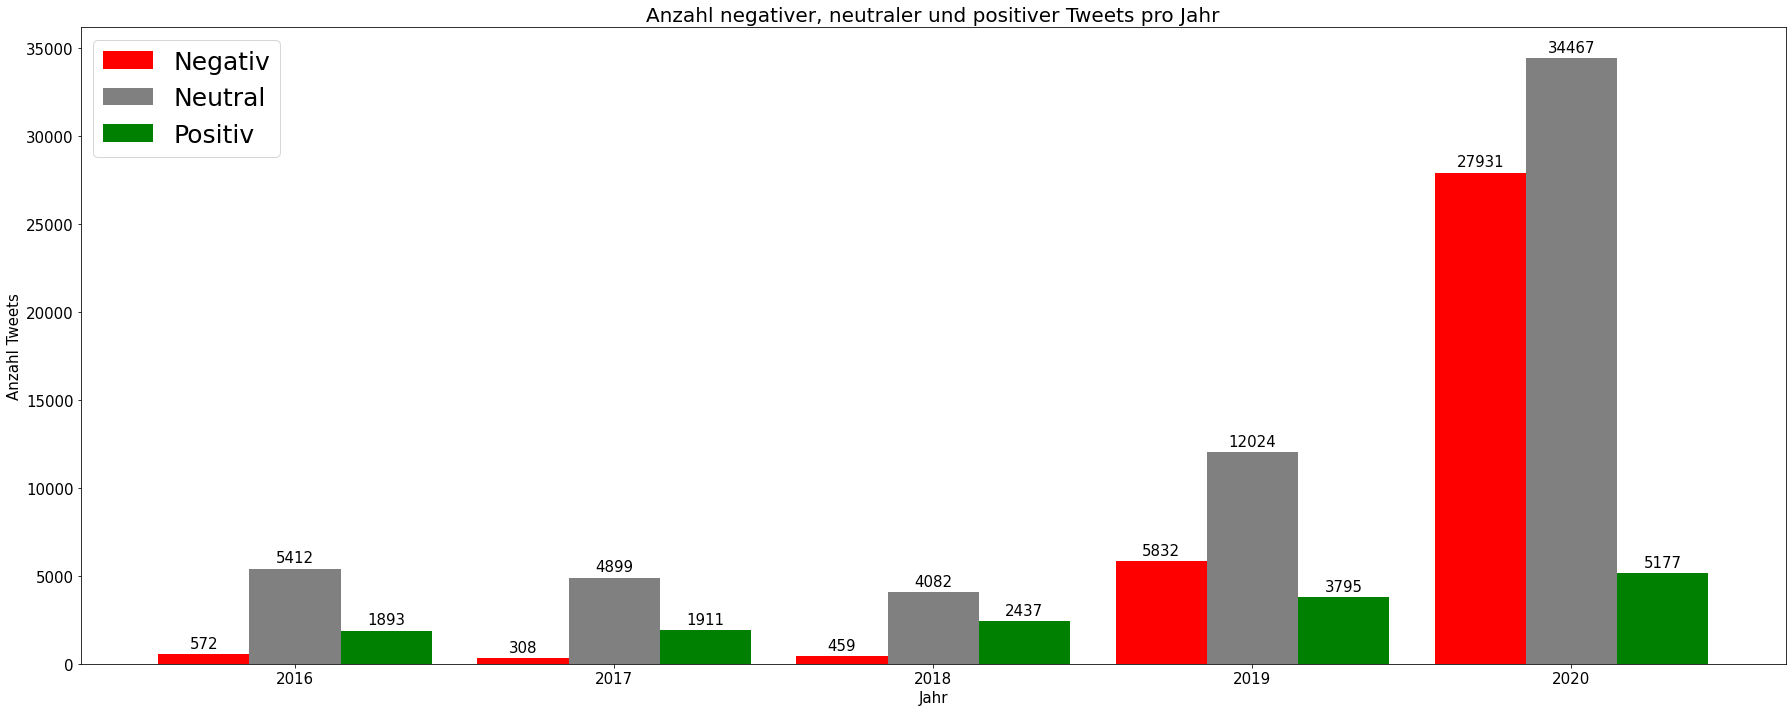

In [414]:
labels = ['2016', '2017', '2018', '2019', '2020']
neg = df_en.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_en.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEG"]["sentiment_bert_value"]
neu = df_en.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_en.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "NEU"]["sentiment_bert_value"]
pos = df_en.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index().loc[df_en.groupby(["Year", "sentiment_bert"])["sentiment_bert_value"].count().reset_index()["sentiment_bert"] == "POS"]["sentiment_bert_value"]

x = [-0.2, 1.2, 2.6, 4, 5.4]
width = 0.4  # the width of the bars

bar_1 = [-0.6, 0.8, 2.2, 3.6, 5]
bar_2 = [-0.2, 1.2, 2.6, 4, 5.4]
bar_3 = [0.2, 1.6, 3, 4.4, 5.8]

fig, ax = plt.subplots(figsize=(25,10))
rects1 = ax.bar(bar_1, neg, width, label='Negativ', color="red")
rects2 = ax.bar(bar_2, neu, width, label='Neutral', color="grey")
rects3 = ax.bar(bar_3, pos, width, label="Positiv", color="green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anzahl Tweets', fontsize=(15))
ax.set_xlabel('Jahr', fontsize=(15))
ax.set_title('Anzahl negativer, neutraler und positiver Tweets pro Jahr', fontsize=(20))
ax.set_xticks(x, labels, fontsize=(15))
ax.legend(fontsize=(25))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(15)

ax.bar_label(rects1, padding=3, fontsize=(15))
ax.bar_label(rects2, padding=3, fontsize=(15))
ax.bar_label(rects3, padding=3, fontsize=(15))

fig.tight_layout()

plt.show()

In [417]:
df_de["sentiment_vader_value"]

0         0
1         1
2         1
3         0
4         0
         ..
114439    1
114440    0
114441    0
114442    0
114443    1
Name: sentiment_vader_value, Length: 114444, dtype: int64

In [423]:
df_de.groupby("sentiment_vader_value")["sentiment_vader"].count()

sentiment_vader_value
-1    34702
 0    33090
 1    46652
Name: sentiment_vader, dtype: int64

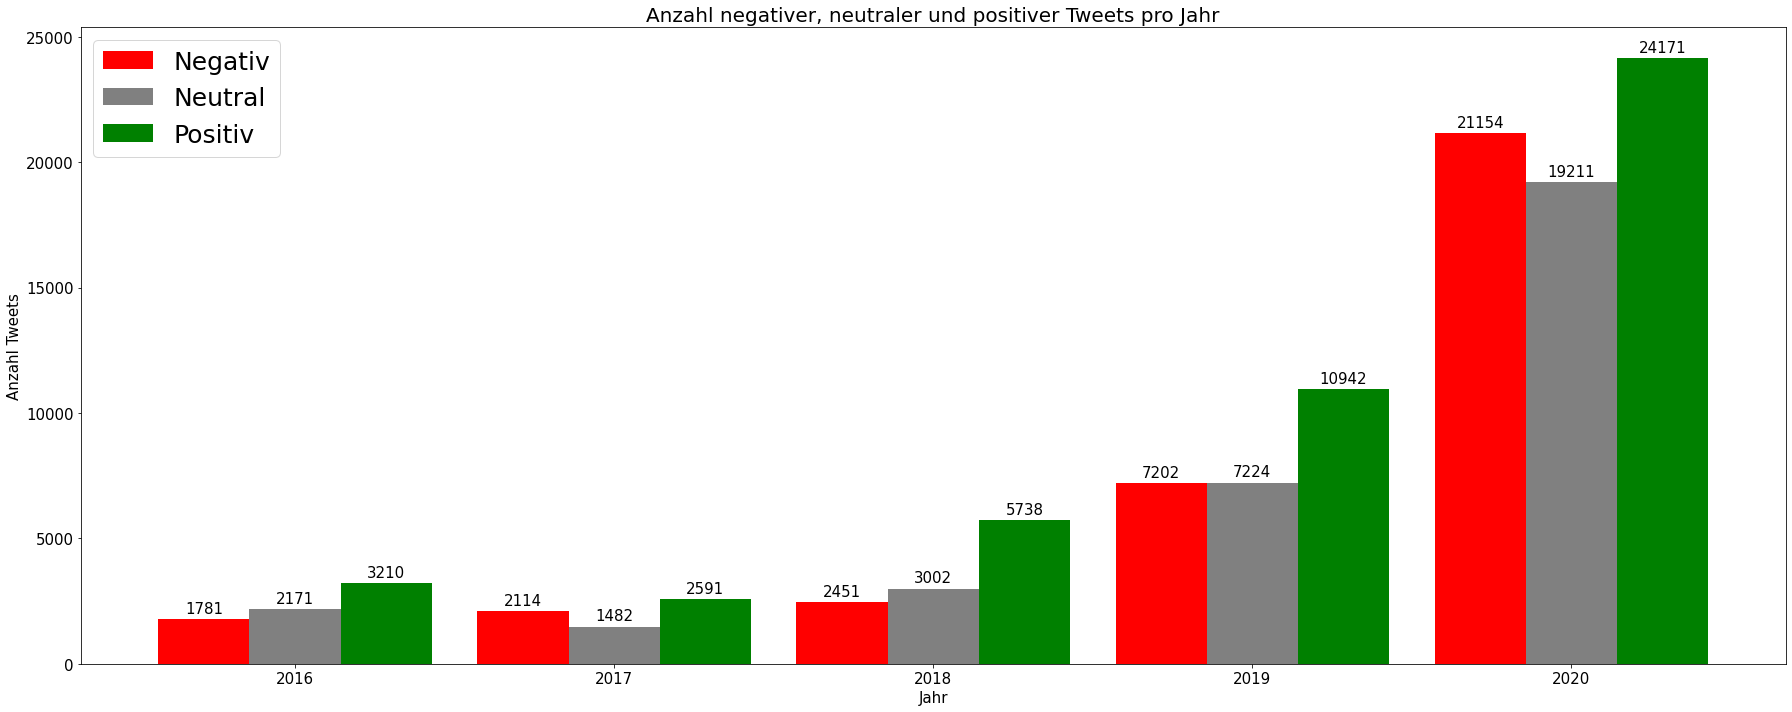

In [424]:
labels = ['2016', '2017', '2018', '2019', '2020']
neg = df_de.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index()["sentiment_vader_value"] == -1]["sentiment_vader"]
neu = df_de.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index()["sentiment_vader_value"] == 0]["sentiment_vader"]
pos = df_de.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index().loc[df_de.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index()["sentiment_vader_value"] == 1]["sentiment_vader"]

x = [-0.2, 1.2, 2.6, 4, 5.4]
width = 0.4  # the width of the bars

bar_1 = [-0.6, 0.8, 2.2, 3.6, 5]
bar_2 = [-0.2, 1.2, 2.6, 4, 5.4]
bar_3 = [0.2, 1.6, 3, 4.4, 5.8]

fig, ax = plt.subplots(figsize=(25,10))
rects1 = ax.bar(bar_1, neg, width, label='Negativ', color="red")
rects2 = ax.bar(bar_2, neu, width, label='Neutral', color="grey")
rects3 = ax.bar(bar_3, pos, width, label="Positiv", color="green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anzahl Tweets', fontsize=(15))
ax.set_xlabel('Jahr', fontsize=(15))
ax.set_title('Anzahl negativer, neutraler und positiver Tweets pro Jahr', fontsize=(20))
ax.set_xticks(x, labels, fontsize=(15))
ax.legend(fontsize=(25))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(15)

ax.bar_label(rects1, padding=3, fontsize=(15))
ax.bar_label(rects2, padding=3, fontsize=(15))
ax.bar_label(rects3, padding=3, fontsize=(15))

fig.tight_layout()

plt.show()

In [427]:
len(df_de.loc[df_de["sentiment_vader_value"] == 1]) / len(df_de)

0.40764041802104084

In [428]:
df_en.groupby("sentiment_vader_value")["sentiment_vader"].count()

sentiment_vader_value
-1    37868
 0    37229
 1    36102
Name: sentiment_vader, dtype: int64

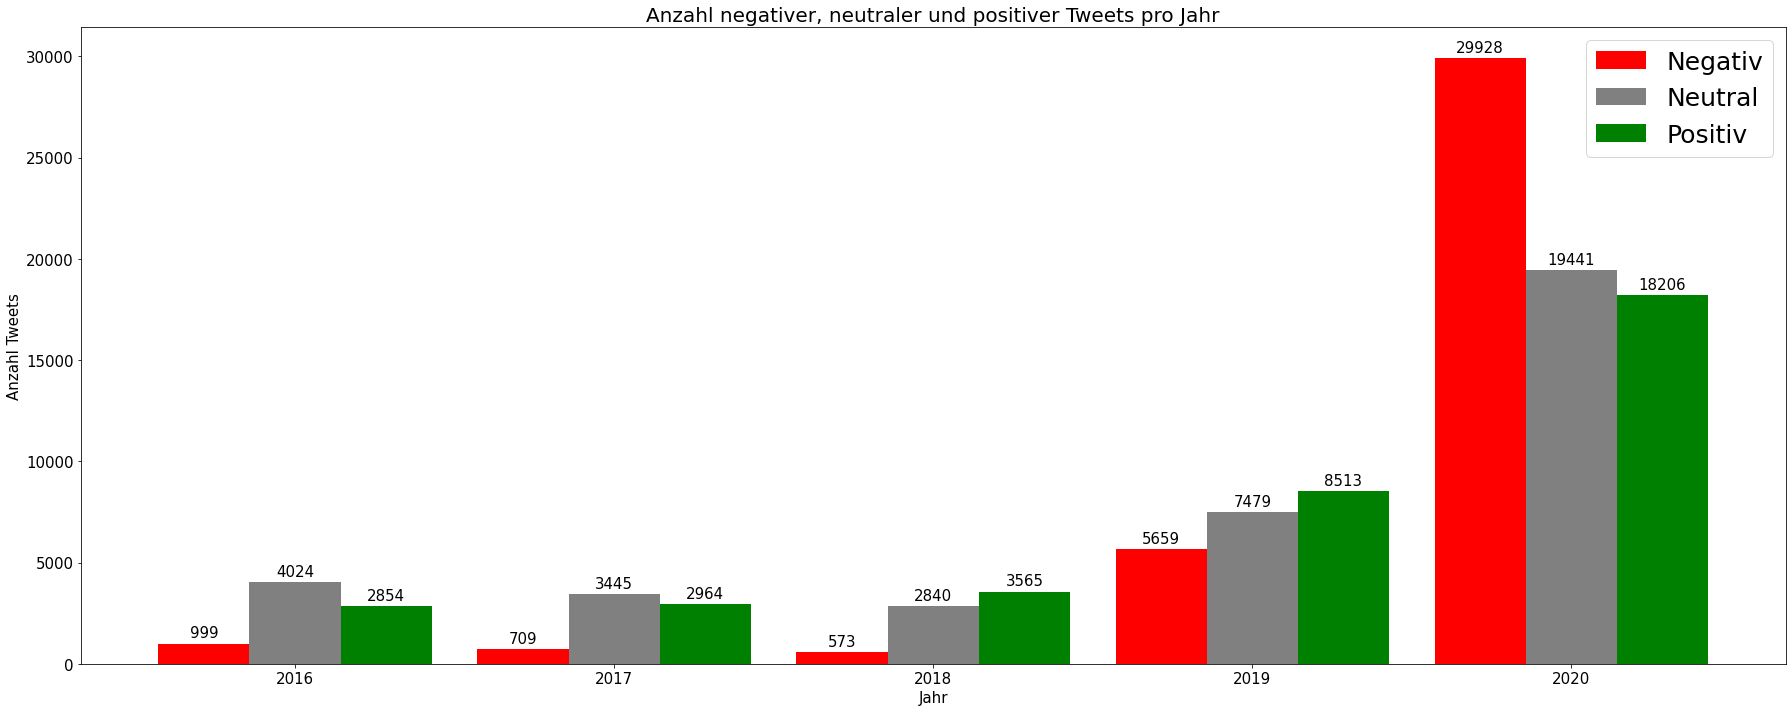

In [429]:
labels = ['2016', '2017', '2018', '2019', '2020']
neg = df_en.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index().loc[df_en.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index()["sentiment_vader_value"] == -1]["sentiment_vader"]
neu = df_en.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index().loc[df_en.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index()["sentiment_vader_value"] == 0]["sentiment_vader"]
pos = df_en.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index().loc[df_en.groupby(["Year", "sentiment_vader_value"])["sentiment_vader"].count().reset_index()["sentiment_vader_value"] == 1]["sentiment_vader"]

x = [-0.2, 1.2, 2.6, 4, 5.4]
width = 0.4  # the width of the bars

bar_1 = [-0.6, 0.8, 2.2, 3.6, 5]
bar_2 = [-0.2, 1.2, 2.6, 4, 5.4]
bar_3 = [0.2, 1.6, 3, 4.4, 5.8]

fig, ax = plt.subplots(figsize=(25,10))
rects1 = ax.bar(bar_1, neg, width, label='Negativ', color="red")
rects2 = ax.bar(bar_2, neu, width, label='Neutral', color="grey")
rects3 = ax.bar(bar_3, pos, width, label="Positiv", color="green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Anzahl Tweets', fontsize=(15))
ax.set_xlabel('Jahr', fontsize=(15))
ax.set_title('Anzahl negativer, neutraler und positiver Tweets pro Jahr', fontsize=(20))
ax.set_xticks(x, labels, fontsize=(15))
ax.legend(fontsize=(25))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(15)

ax.bar_label(rects1, padding=3, fontsize=(15))
ax.bar_label(rects2, padding=3, fontsize=(15))
ax.bar_label(rects3, padding=3, fontsize=(15))

fig.tight_layout()

plt.show()

In [14]:
df_de

,conversation_id,author_id,created_at,tweet_id,lang,retweet_count,reply_count,like_count,quote_count,source,tweet_type,referenced_tweet_id,text,sentiment_bert,sentiment_vader,Date,sentiment_bert_value,sentiment_vader_value,Week,Year
0,703311366262800384,1392131804,2016-02-26 20:11:11+00:00,703311366262800384,de,0,0,2,0,Twitter Web Client,None,None,Wirecard-Chef Markus Braun pumpt irrwitzige Su...,NEU,0.0000,2016-02-26,0,0,8,2016
1,702405572012974080,1053723204,2016-02-24 08:11:53+00:00,702405572012974080,de,0,0,0,0,Twitter Web Client,None,None,Jetzt günstig einsammeln und später absahnen? ...,NEU,0.4871,2016-02-24,0,1,8,2016
2,700578193334411264,19811837,2016-02-19 07:10:32+00:00,700578193334411264,de,2,0,0,0,Twitter Web Client,None,None,Wirecard: Was führt der Vorstand im Schilde? M...,NEU,0.3182,2016-02-19,0,1,7,2016
3,700221272840601601,19811837,2016-02-18 07:32:15+00:00,700221272840601601,de,0,0,1,0,Twitter Web Client,None,None,Wirecard-Vorstand kauft weiter massiv eigene A...,NEG,0.0000,2016-02-18,-1,0,7,2016
4,697324084221227008,183289696,2016-02-10 07:39:51+00:00,697324084221227008,de,0,0,0,0,dlvr.it,None,None,📈 Wirecard: Serie von Aktienkäufen des Vorstan...,NEU,0.0000,2016-02-10,0,0,6,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114439,1164960547693105153,4584354895,2019-08-23 18:00:13+00:00,1164960547693105153,de,0,0,0,0,tickwatcher,None,None,Top Gainers (&gt;30)UVXY JNUG DRIP OPYGY URR E...,NEG,0.5574,2019-08-23,-1,1,34,2019
114440,1228994498610503680,704753138146877440,2020-02-17 17:53:29+00:00,1229463896425205768,de,0,0,2,0,Twitter Web App,replied_to,1229459682403725314,1/ Die Anwälte der Klägerseit...,NEU,0.0000,2020-02-17,0,0,8,2020
114441,1228017316375539712,1138485557502382082,2020-02-13 18:09:16+00:00,1228018315785838593,de,0,0,0,1,Twitter for iPhone,replied_to,1228017316375539712,Ist nicht der WRCDF LV Anteil mit zusätzlichen...,NEG,0.0000,2020-02-13,-1,0,7,2020
114442,1275070899822059523,1001192245,2020-06-22 14:19:26+00:00,1275070899822059523,de,0,0,0,0,TalkMarketsApp,None,None,Olaf Scholz - The German Finance Minister Is D...,NEU,0.0000,2020-06-22,0,0,26,2020
